<a href="https://colab.research.google.com/github/assafrbi/mini-project-Digital-Humanities/blob/main/dh_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!pip install cinemagoer
!pip install pyLDAvis
!pip install swifter

import re
from pydoc import synopsis
import requests
from bs4 import BeautifulSoup
from dateutil.parser import parse
import concurrent.futures
import pandas as pd
# import wikipedia
import numpy as np
import json
import glob
from imdb import Cinemagoer
import tqdm
import time
import nltk
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from nltk.corpus import stopwords
nltk.download('all')
import pyLDAvis
import pyLDAvis.gensim_models
import collections
from operator import itemgetter
from scipy import stats
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import swifter
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

### Load Data from IMDb

In [ ]:
movie_title_arr = []
movie_year_arr = []
movie_genre_arr = []
image_id_arr = []
movie_synopsis_arr = []
need_wiki_id = []
need_wiki_name = []
need_wiki_year = []

In [ ]:
ia = Cinemagoer()

def getSynopsisFromImdb(id):
  movie = ia.get_movie(id)
  plot = movie.get('plot')[0]
  indx = plot.find('::')
  if indx != -1:
    return plot[:indx]
  return plot

In [ ]:
def getMovieTitle(header):
  try:
    return header[0].find("a").getText()
  except:
    return 'NA'

def getReleaseYear(header):
  try:
    return header[0].find("span",  {"class": "lister-item-year text-muted unbold"}).getText().strip()[-5:-1]
  except:
    return 'NA'

def getGenre(muted_text):
  try:
    return muted_text.find("span",  {"class":  "genre"}).getText().strip()
  except:
    return 'NA'
        
def getsynopsys(movie, id, name, year):
  try:
    movie_synopsis = getSynopsisFromImdb(id)
    return movie_synopsis
  except:
    # no imdb data -> need wiki
    need_wiki_id.append(id)
    need_wiki_name.append(name)
    need_wiki_year.append(year)
    return 'NA'

def getImageId(image):
  try:
    return image.get('data-tconst')[2:]
  except:
    return 'NA'

In [ ]:
def main(imdb_url):
  response = requests.get(imdb_url)
  soup = BeautifulSoup(response.text, 'html.parser')

  # Movie Name
  movies_list  = soup.find_all("div", {"class": "lister-item mode-advanced"})
    
  for movie in movies_list:
    header = movie.find_all("h3", {"class":  "lister-item-header"})
    muted_text = movie.find_all("p", {"class":  "text-muted"})[0]
    imageDiv =  movie.find("div", {"class": "lister-item-image float-left"})
    image = imageDiv.find("img", "loadlate")
        
    # Movie Title
    movie_title = getMovieTitle(header)
    movie_title_arr.append(movie_title)

    # Movie id
    id = getImageId(image)
    image_id_arr.append(id)
        
    # Movie release year
    year = getReleaseYear(header)
    movie_year_arr.append(year)

    # Movie Synopsys
    synopsis = getsynopsys(movie, id, movie_title, year)
    movie_synopsis_arr.append(synopsis)
        
    # Genre
    genre = getGenre(muted_text)
    movie_genre_arr.append(genre)
        

In [ ]:
# An array to store all the URL that are being queried
imageArr = []

# Maximum number of pages one wants to iterate over
MAX_PAGE =51

# Loop to generate all the URLS.
for i in range(1, 1500, 50):
  imdb_url = f'https://www.imdb.com/search/title/?title_type=feature&countries=il&start={i}&ref_=adv_nxt'
  imageArr.append(imdb_url)

In [ ]:
# Maximum number of threads that will be spawned
MAX_THREADS = 6

def download_stories(story_urls):
  threads = min(MAX_THREADS, len(story_urls))
  with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
    time.sleep(0.3)
    executor.map(main, story_urls)

In [ ]:
# Call the download function with the array of URLS called imageArr
download_stories(imageArr)

# Attach all the data to the pandas dataframe. You can optionally write it to a CSV file as well
movieDf = pd.DataFrame({
    "Title": movie_title_arr,
    "Year": movie_year_arr,
    "Genre": movie_genre_arr,
    "Synopsis": movie_synopsis_arr,
    "IMDb id": image_id_arr,
})

needWiki = pd.DataFrame({
    "Title": need_wiki_name,
    "Year": need_wiki_year,
    "IMDb id": need_wiki_id,
})

movieDf.to_csv('israel_originated_movies_imdb.csv')
needWiki.to_csv('movies_need_wiki.csv')

In [ ]:
movieDf

,Title,Year,Genre,Synopsis,IMDb id
0,The Lost Daughter,2021,"Comedy, Drama",A young Israeli man absconds to Paris to flee ...,9100054
1,A Story of David,1960,Drama,A woman's beach vacation takes a dark turn whe...,0054342
2,Rumpelstiltskin,1987,Drama,King Saul of Israel is jealous of the fame and...,0093891
3,Bloomfield,1970,Drama,"Secrets, lies, surprises and more are explored...",0068694
4,Synonymes,2019,"Drama, Sport",Eitan is yesterday's football star waiting for...,7016254
...,...,...,...,...,...
1466,BaKavod Sheli,2004,Drama,NA,8317822
1467,Outcry,1998,Horror,NA,9354814
1468,Alenbi Romance,2005,"Drama, Romance","""All of those romantic movies are always in fo...",0808145
1469,Street 60,1976,"Drama, Romance",NA,5524664


In [ ]:
needWiki

,Title,Year,IMDb id
0,Summertime Blues: Lemon Popsicle VIII,1988,0096190
1,Lemon Popsicle 9: The Party Goes On,2001,0289730
2,Me'ever Layam,1991,0104834
3,La salamandra del deserto,1970,0067700
4,Tell Me That You Love Me,1983,0086422
...,...,...,...
334,Free Man's Blood or The Sykariki,1970,0406787
335,LeShem Shenuy,2018,13136008
336,BaKavod Sheli,2004,8317822
337,Outcry,1998,9354814


In [ ]:
complete_data = pd.read_csv('israel_originated_movies_imdb.csv', usecols=["Synopsis","Genre"]).dropna()
complete_data.to_csv('ready_for_topic_modeling.csv', index=False)

complete_data

,Genre,Synopsis
0,"Comedy, Drama",A young Israeli man absconds to Paris to flee ...
1,Drama,A woman's beach vacation takes a dark turn whe...
2,Drama,King Saul of Israel is jealous of the fame and...
3,Drama,"Secrets, lies, surprises and more are explored..."
4,"Drama, Sport",Eitan is yesterday's football star waiting for...
...,...,...
1459,Comedy,BlackSmile Challenging Himself To Create A 49 ...
1460,"Comedy, Drama",A sham marriage for the sake of a UK residence...
1465,Drama,The story of a young soldier in the Israeli ar...
1468,"Drama, Romance","""All of those romantic movies are always in fo..."


### Load Synopses from Wikipedia - Need some tuning !!!!!!

In [ ]:
# wikiMovies = pd.read_csv('movies_need_wiki.csv')

In [ ]:
# movie_plot_arr = []
# movie_summary_arr = []
# wikipedia_title_arr = []

# def find_title_on_wikipedia(title, year):
#     search_results = wikipedia.search(title, results=20)
#     search_results_exact = [s for s in search_results if title in s] # results that have the exact title as part of them
    
#     if len(search_results_exact) != 0: # if the title is part of at least one result

#         # if film exists in title but not together with series or score (an example was Resident Evil 2002)
#         search_results_film = [s for s in search_results_exact if 'film' in s and 'score' not in s and 'series' not in s]

#         # Go on by additionaly searching for the year in the title
#         if len(search_results_film) == 0: # if there is no results with 'film' in the title
#             search_results_year = [s for s in search_results_exact if str(year) in s]
#             if len(search_results_year) == 0: # if there is no results with year in the title
#                 search_results_final = search_results_exact
#             else:
#                 search_results_final = search_results_year
#         else:
#             search_results_year = [s for s in search_results_film if str(year) in s]
#             if len(search_results_year) == 0:
#                 search_results_final = search_results_film
#             else:
#                 search_results_final = search_results_year  

#         # for the possible remains of the search results take the exact match or the first result
#         for s in search_results_final:
#             if s == title:
#                 title = s
#             else:
#                 title = search_results_final[0]
    
#     else: # take the first result
#         title = search_results[0]

#     return title

# def add_wikipedia():
#   section_names = ['Plot','Synopsis','Plot synopsis','Plot summary', 'Story','Plotline','The Beginning','Summary', 'Content','Premise']
#   for i in range (len(image_id_arr)):
#     imdb_title = movie_title_arr[i]
#     year = movie_year_arr[i]
#     title, page, plot, summary = np.nan, np.nan, np.nan, np.nan

#     try:
#       title = find_title_on_wikipedia(imdb_title, year)
#       search_results = wikipedia.search(title, results=20)
#       page = wikipedia.WikipediaPage(title = title)
#     except:
#         print(f'Title "{imdb_title}" does not exist on Wikipedia.')

#     for section in section_names:
#         try:
#             plot = page.section(section)
#         except:
#             print(f'Plot for -{imdb_title}- was not found.')

#     # for some movies with general title - modify the search by adding (year film) next to title
#     if plot is None:
#         imdb_title = f'{imdb_title} ({year} film)'
#         try:          
#             title = find_title_on_wikipedia(imdb_title, year)
#             search_results = wikipedia.search(title, results=20)
#             page = wikipedia.WikipediaPage(title = title)
#         except:
#             print(f'Title "{imdb_title}" does not exist on Wikipedia.')

#         for section in section_names:
#             try:
#                 plot = page.section(section)
#             except:
#               print(f'Plot for -{imdb_title}- was not found.')
        
#     try:
#         summary = page.summary
#     except:
#         print(f'Summary for -{imdb_title}- was not found.')        
    
#     wikipedia_title_arr.append(title)
#     movie_plot_arr.append(plot)
#     movie_summary_arr.append(summary)

In [ ]:
# data = pd.read_csv('israel_originated_movies_imdb.csv')
# add_wikipedia()

### Text Preprocessing

 Tokenize and Clean

In [8]:
def remove_new_line_characters(text):
  return re.sub('\s+', ' ', text)

def remove_quotes(text):
  text = re.sub("\'", "", text)
  text = re.sub('\"', '', text)
  return text

def lowercase(text):
  return text.lower()    

def remove_single_char_words(text):
  return re.sub(r"\b[a-zA-Z]\b", "", text)

def remove_verbs(text):
  final_text = ''
  allowedWordTypes = ["J","R","N"]
  tokens = nltk.word_tokenize(text)
  tagged = nltk.pos_tag(tokens)
  for w in tagged:
    if w[1][0] in allowedWordTypes:
      final_text += f' {w[0]}'
  return final_text

def text_preprocess(text):
  text = remove_new_line_characters(text)
  text = remove_quotes(text)
  text = lowercase(text)
  text = remove_single_char_words(text)
  text = remove_verbs(text)
  return text

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [14]:
ready_data = pd.read_csv('ready_for_topic_modeling.csv', usecols=["Synopsis", "Genre"])

ready_data.loc[ready_data['Synopsis']!='']
source = 'Synopsis'
data = ready_data.copy()

print(f'---Doing pre-processing for {source}..')
print('Initial pre-processing..')

data[source] = data[source].apply(lambda x: text_preprocess(x))

data = data[source].to_list()
data_words = list(sent_to_words(data))
data_words

---Doing pre-processing for Synopsis..
Initial pre-processing..


[['young',
  'israeli',
  'man',
  'nationality',
  'trusty',
  'franco',
  'israeli',
  'dictionary'],
 ['womans', 'vacation', 'dark', 'turn', 'troubles', 'past'],
 ['saul',
  'israel',
  'jealous',
  'fame',
  'adoration',
  'david',
  'long',
  'ago',
  'slew',
  'goliath',
  'victory',
  'armies',
  'now',
  'edomite',
  'counselor',
  'doeg',
  'attempts',
  'david',
  'sauls',
  'son',
  'davids',
  'best',
  'jonathan',
  'reluctant',
  'back',
  'own',
  'people',
  'israelites'],
 ['secrets',
  'lies',
  'surprises',
  'more',
  'rich',
  'selection',
  'gay',
  'short',
  'films',
  'israel'],
 ['eitan',
  'yesterdays',
  'football',
  'star',
  'tomorrow',
  'man',
  'nothing',
  'guts',
  'prospects',
  'new',
  'profession',
  'woman',
  'problems'],
 ['musical',
  'version',
  'classic',
  'story',
  'millers',
  'help',
  'mischievous',
  'dwarf',
  'then',
  'up',
  'head',
  'now',
  'servant',
  'girl',
  'only',
  'hope',
  'baby',
  'son',
  'john'],
 ['father',
  '

Build the Bigram, Trigram Models and Lemmatize

In [20]:
stopwords = nltk.corpus.stopwords.words('english')
extendedStopWords = ['film', 'israeli']
stopwords.extend(extendedStopWords)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def make_bigrams(texts, bigram_mod):
  return [bigram_mod[doc] for doc in texts]
  
def lemmatization_x(sent, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  doc = nlp(" ".join(sent)) 
  return [token.lemma_ for token in doc if token.pos_ in allowed_postags]

def join_list(the_list):
  str1 = " " 
  return str1.join(the_list)

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

In [22]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100, progress_per=200) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Remove Stop Words
print('Removing stopwords..')
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
print('Creating bigrams..')
ready_data[f'{source}_words_bigrams'] = make_bigrams(data_words_nostops, bigram_mod)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python -m spacy download en_core_web_sm

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print('Lemmatizing words..')
ready_data[f'{source}_lemmatized'] = ready_data[f'{source}_words_bigrams'].swifter.apply(lambda x: lemmatization_x(x))
ready_data = ready_data.drop(columns=[f'{source}_words_bigrams'])
ready_data[f'{source}_preprocessed'] = ready_data[f'{source}_lemmatized'].apply(lambda x: join_list(x))

del bigram, bigram_mod, data_words, data, nlp

ready_data

Removing stopwords..
Creating bigrams..
Lemmatizing words..


Pandas Apply:   0%|          | 0/1118 [00:00<?, ?it/s]

,Genre,Synopsis,Synopsis_lemmatized,Synopsis_preprocessed
0,"Comedy, Drama",A young Israeli man absconds to Paris to flee ...,"[young, man, nationality]",young man nationality
1,Drama,A woman's beach vacation takes a dark turn whe...,"[vacation, dark, turn, trouble, past]",vacation dark turn trouble past
2,Drama,King Saul of Israel is jealous of the fame and...,"[adoration, long, ago, victory, army, attempt,...",adoration long ago victory army attempt good p...
3,Drama,"Secrets, lies, surprises and more are explored...","[secret, lie, surprise, rich, selection, gay, ...",secret lie surprise rich selection gay short film
4,"Drama, Sport",Eitan is yesterday's football star waiting for...,"[tomorrow, man, gut, prospect, new, profession...",tomorrow man gut prospect new profession woman...
...,...,...,...,...
1113,Comedy,BlackSmile Challenging Himself To Create A 49 ...,"[blacksmile, minute, movie, full, youtube, con...",blacksmile minute movie full youtube content
1114,"Comedy, Drama",A sham marriage for the sake of a UK residence...,"[marriage, sake, partnership, man, british, wo...",marriage sake partnership man british woman al...
1115,Drama,The story of a young soldier in the Israeli ar...,"[story, young, soldier, army, people, home, la...",story young soldier army people home land deep...
1116,"Drama, Romance","""All of those romantic movies are always in fo...","[romantic, movie, always, foreign, city, alway...",romantic movie always foreign city always easy...


#### Most common words


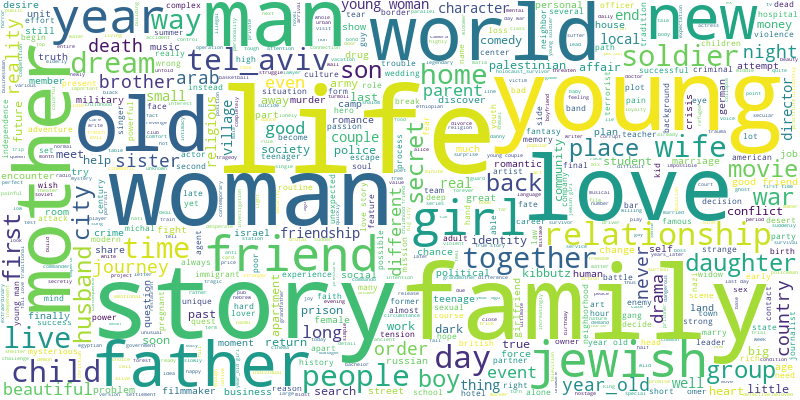

In [23]:
# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white",
    max_words=2000,
    contour_width=3,
    contour_color='steelblue',
    width=800,
    height=400)
# Join the different processed titles together.
long_string = ','.join(ready_data[f'{source}_preprocessed'].to_list())
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Topic Modeling - Latent Dirichlet Allocation

Build The Topic Model

In [24]:
def build_LDA_model(ready_data, source, num_topics):
  # Create the Dictionary and Corpus needed for Topic Modeling
  # Create Dictionary
  id2word = corpora.Dictionary(ready_data[f'{source}_lemmatized'].tolist())
  # Create Corpus
  texts = ready_data[f'{source}_lemmatized'].tolist()
  # Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in texts]
  del texts
  
  # Build LDA model
  lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=7,
                                               eval_every=10,
                                               chunksize=100,
                                               passes=10,
                                               per_word_topics=True,
                                               workers=8)   
  return lda_model, corpus, id2word

def allocate_topics(i, lda_model):
  return lda_model[corpus[i]][0]

def get_max_probability_topic(x, num_topics):
  return max(x, key=itemgetter(1))[0]

In [25]:
num_topics = 10
lda_model, corpus, id2word = build_LDA_model(ready_data, source=source, num_topics=num_topics)
lda_model.save('lda_model')

lda_model.print_topics()

[(0,
  '0.015*"family" + 0.012*"life" + 0.011*"story" + 0.010*"man" + 0.010*"woman" + 0.010*"old" + 0.009*"mother" + 0.008*"young" + 0.007*"day" + 0.007*"son"'),
 (1,
  '0.015*"young" + 0.010*"family" + 0.008*"friend" + 0.007*"life" + 0.007*"story" + 0.007*"man" + 0.007*"affair" + 0.006*"year" + 0.006*"jewish" + 0.006*"question"'),
 (2,
  '0.020*"life" + 0.019*"story" + 0.013*"family" + 0.011*"love" + 0.011*"woman" + 0.009*"young" + 0.008*"new" + 0.008*"girl" + 0.007*"true" + 0.007*"jewish"'),
 (3,
  '0.012*"story" + 0.010*"young" + 0.009*"life" + 0.009*"woman" + 0.007*"new" + 0.006*"family" + 0.006*"jewish" + 0.006*"man" + 0.006*"process" + 0.005*"world"'),
 (4,
  '0.015*"young" + 0.013*"woman" + 0.011*"story" + 0.010*"arab" + 0.007*"man" + 0.007*"life" + 0.006*"group" + 0.006*"battle" + 0.006*"day" + 0.006*"love"'),
 (5,
  '0.013*"story" + 0.009*"year" + 0.008*"movie" + 0.007*"day" + 0.007*"war" + 0.006*"tel_aviv" + 0.006*"young" + 0.006*"character" + 0.006*"home" + 0.005*"old"'),
 (

### Evaluation

In [26]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -8.351070900182085


Assign Dominant Topic to each record

In [27]:
ready_data['i'] = [i for i in range(len(ready_data))]
ready_data[f'{source}_topic'] = ready_data['i'].swifter.apply(lambda x: allocate_topics(x, lda_model))
ready_data[f'{source}_topic'] = ready_data[f'{source}_topic'].apply(lambda x: get_max_probability_topic(x, num_topics))

ready_data

Pandas Apply:   0%|          | 0/1118 [00:00<?, ?it/s]

,Genre,Synopsis,Synopsis_lemmatized,Synopsis_preprocessed,i,Synopsis_topic
0,"Comedy, Drama",A young Israeli man absconds to Paris to flee ...,"[young, man, nationality]",young man nationality,0,4
1,Drama,A woman's beach vacation takes a dark turn whe...,"[vacation, dark, turn, trouble, past]",vacation dark turn trouble past,1,2
2,Drama,King Saul of Israel is jealous of the fame and...,"[adoration, long, ago, victory, army, attempt,...",adoration long ago victory army attempt good p...,2,1
3,Drama,"Secrets, lies, surprises and more are explored...","[secret, lie, surprise, rich, selection, gay, ...",secret lie surprise rich selection gay short film,3,6
4,"Drama, Sport",Eitan is yesterday's football star waiting for...,"[tomorrow, man, gut, prospect, new, profession...",tomorrow man gut prospect new profession woman...,4,0
...,...,...,...,...,...,...
1113,Comedy,BlackSmile Challenging Himself To Create A 49 ...,"[blacksmile, minute, movie, full, youtube, con...",blacksmile minute movie full youtube content,1113,9
1114,"Comedy, Drama",A sham marriage for the sake of a UK residence...,"[marriage, sake, partnership, man, british, wo...",marriage sake partnership man british woman al...,1114,1
1115,Drama,The story of a young soldier in the Israeli ar...,"[story, young, soldier, army, people, home, la...",story young soldier army people home land deep...,1115,5
1116,"Drama, Romance","""All of those romantic movies are always in fo...","[romantic, movie, always, foreign, city, alway...",romantic movie always foreign city always easy...,1116,5


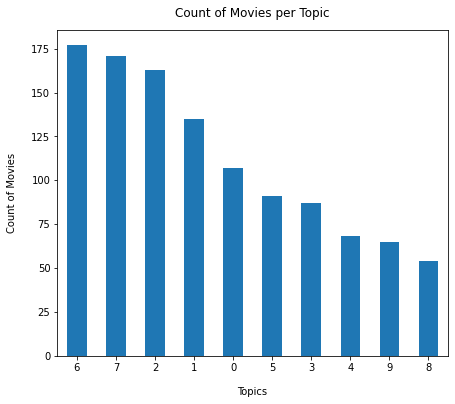

In [38]:
ready_data[f'{source}_topic'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0);
plt.xlabel("Topics", labelpad=14)
plt.ylabel("Count of Movies", labelpad=14)
plt.title("Count of Movies per Topic", y=1.02);

### Visualize Topics


Word Clouds of Top N Keywords in Each Topic

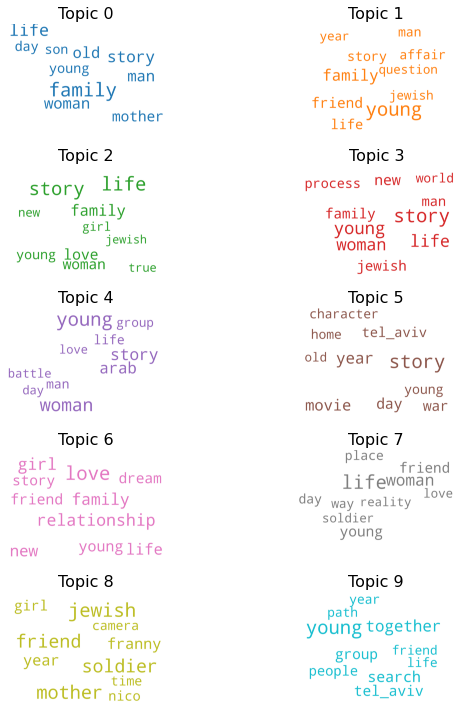

In [30]:
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(int(num_topics/2), 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [31]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.115081 -0.024932       1        1  17.353710
7     -0.065816 -0.086390       2        1  15.904273
2     -0.093434  0.049688       3        1  12.776828
1     -0.032759  0.020445       4        1  11.440999
0     -0.007507  0.044990       5        1   9.811691
3      0.023854  0.041213       6        1   8.495274
5      0.073070  0.090204       7        1   8.408748
9      0.071153 -0.147636       8        1   6.309450
4      0.051668  0.026685       9        1   5.395291
8      0.094854 -0.014266      10        1   4.103735, topic_info=          Term        Freq       Total Category  logprob  loglift
41       story  182.000000  182.000000  Default  30.0000  30.0000
323     family  149.000000  149.000000  Default  29.0000  29.0000
366       arab   33.000000   33.000000  Default  28.0000  28.0000
164     mother   73.000000   73.000000  Default  27.0000  27.0000
458    soldier   60.000000   60.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
222        old    2.868535   89.692360  Topic10  -5.6340  -0.2493
624     couple    2.646894   34.207318  Topic10  -5.7144   0.6342
491  beautiful    2.630523   32.252785  Topic10  -5.7206   0.6869
992     prison    2.567869   22.875910  Topic10  -5.7447   1.0063
0          man    2.714835  100.414653  Topic10  -5.6891  -0.4173

[720 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2110      3  0.881681        abuse
2589     10  0.722744      abutbul
498       1  0.165554          act
498       2  0.827770          act
2244      1  0.909342  adolescence
...     ...       ...          ...
4368     10  0.448128         yuda
4658      8  0.698667      zealous
3422      7  0.842769      zionism
4579      7  0.913806       zodiac
4404      4  0.792301        zurim

[1552 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 3, 2, 1, 4, 6, 10, 5, 9])

Word Counts of Topic Keywords

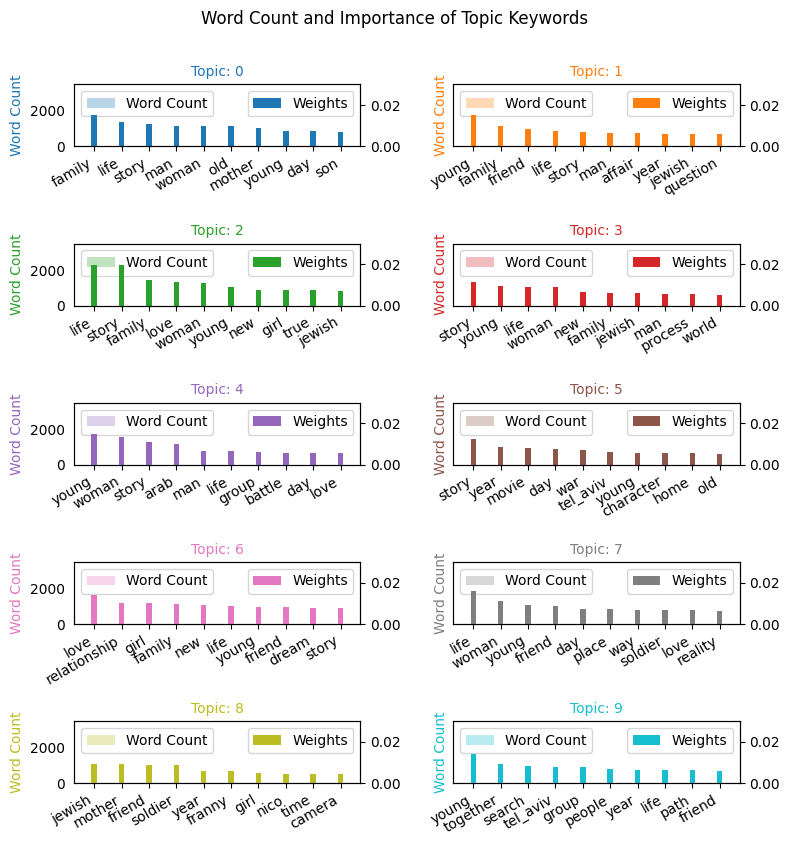

In [33]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in ready_data for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(int(num_topics/2), 2, figsize=(8,8), sharey=True, dpi=100)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=10)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=12, y=1.05)    
plt.show()